In [1]:
import ROOT

Welcome to JupyROOT 6.28/00


In [2]:
import glob

In [3]:
mass = '200'

indir_nano = '/data_CMS/cms/vernazza/MCProduction/2023_11_14/MyPrivateGridpacks'
indir_prep = '/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10'

# files = glob.glob(indir_prep + f'/gg_X_ZZbbtautau_M{mass}/*')
files = glob.glob(indir_prep + f'/ggXZZbbtt_M{mass}/cat_base_selection/prod_231005/*')

dataframe_files = ROOT.vector(str)()
for f in files:
    dataframe_files.push_back(f)
df = ROOT.RDataFrame("Events", dataframe_files)

In [4]:
ROOT.gInterpreter.Declare("""
                using Vfloat = const ROOT::RVec<float>&;
                using Vint   = const ROOT::RVec<int>&;
                ROOT::RVec<int> find_bb_tautau(Vint GenPart_pdgId, Vint GenPart_genPartIdxMother) {
                    bool Foundbjets = false;
                    bool Foundtaus = false;
                    int index_b1 = -1;
                    int index_b2 = -1;
                    int index_t1 = -1;
                    int index_t2 = -1;
                    for (int i_gen = 0; i_gen < GenPart_pdgId.size(); i_gen ++) {
                        if (GenPart_genPartIdxMother.at(i_gen) == -1) continue; // it is the incoming parton
                        if ((Foundbjets != true) && (fabs(GenPart_pdgId.at(i_gen)) == 5) && (GenPart_pdgId.at(GenPart_genPartIdxMother.at(i_gen)) == 23)) {
                            if (index_b1 == -1) index_b1 = i_gen;
                            else if (index_b2 == -1) index_b2 = i_gen;
                            if ((index_b1 != -1) && (index_b2 != -1)) {
                                Foundbjets = true;
                            }
                        }
                        if ((Foundtaus != true) && (fabs(GenPart_pdgId.at(i_gen)) == 15) && (GenPart_pdgId.at(GenPart_genPartIdxMother.at(i_gen)) == 23)) {
                            if (index_t1 == -1) index_t1 = i_gen;
                            else if (index_t2 == -1) index_t2 = i_gen;
                            if ((index_t1 != -1) && (index_t2 != -1)) {
                                Foundtaus = true;
                            }
                        }
                    }
                    return {index_b1, index_b2, index_t1, index_t2} ;
                }
            """)

True

In [5]:
df = df.Define("index_b1", "find_bb_tautau(GenPart_pdgId, GenPart_genPartIdxMother).at(0)")
df = df.Define("index_b2", "find_bb_tautau(GenPart_pdgId, GenPart_genPartIdxMother).at(1)")
df = df.Define("index_t1", "find_bb_tautau(GenPart_pdgId, GenPart_genPartIdxMother).at(2)")
df = df.Define("index_t2", "find_bb_tautau(GenPart_pdgId, GenPart_genPartIdxMother).at(3)")

In [6]:
ROOT.gInterpreter.Declare("""
                using Vfloat = const ROOT::RVec<float>&;
                using Vint   = const ROOT::RVec<int>&;
                Float_t computeDeltaR(Vfloat GenPart_pt, Vfloat GenPart_eta, Vfloat GenPart_phi, Vfloat GenPart_mass, int index_1, int index_2) {
                    auto part1_tlv = TLorentzVector();
                    auto part2_tlv = TLorentzVector();
                    part1_tlv.SetPtEtaPhiM(GenPart_pt.at(index_1), GenPart_eta.at(index_1), GenPart_phi.at(index_1), GenPart_mass.at(index_1));
                    part2_tlv.SetPtEtaPhiM(GenPart_pt.at(index_2), GenPart_eta.at(index_2), GenPart_phi.at(index_2), GenPart_mass.at(index_2));
                    return part1_tlv.DeltaR(part2_tlv);
                }
            """)

True

In [7]:
df = df.Define("deltaR_bjets", "computeDeltaR(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, index_b1, index_b2)")
df = df.Define("deltaR_taus", "computeDeltaR(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, index_t1, index_t2)")

In [11]:
histo1 = df.Histo1D("deltaR_bjets")
histo2 = df.Histo1D("deltaR_taus")
h1 = histo1.Clone()
h2 = histo2.Clone()

<ErrorbarContainer object of 3 artists>

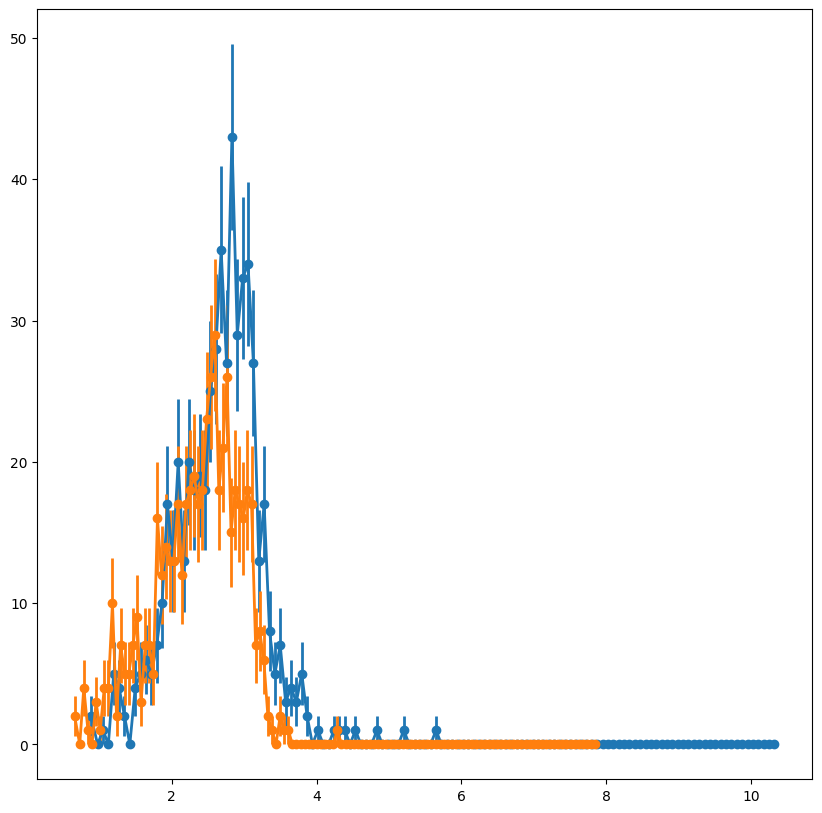

In [12]:
import matplotlib.pyplot as plt

def GetArraysFromHisto(histo):
    X = [] ; Y = [] ; X_err = [] ; Y_err = []
    for ibin in range(0,histo.GetNbinsX()):
        X.append(histo.GetBinLowEdge(ibin+1) + histo.GetBinWidth(ibin+1)/2.)
        Y.append(histo.GetBinContent(ibin+1))
        X_err.append(histo.GetBinWidth(ibin+1)/2.)
        Y_err.append(histo.GetBinError(ibin+1))
    return X,Y,X_err,Y_err

fig, ax = plt.subplots(figsize=(10,10))
X,Y,X_err,Y_err = GetArraysFromHisto(h1)
ax.errorbar(X, Y, xerr=X_err, yerr=Y_err, label="1", lw=2, marker='o')
X,Y,X_err,Y_err = GetArraysFromHisto(h2)
ax.errorbar(X, Y, xerr=X_err, yerr=Y_err, label="1", lw=2, marker='o')